# 👻 Ghost on Local
---
[![Phantom](https://img.shields.io/badge/Version-2.0-teal.svg)]()
[![Phantom](https://img.shields.io/badge/Github-👻-black.svg)](https://github.com/Ming-doan/timeseries-imputation.git)

In [49]:
import pandas as pd
from modules.alias import get_by_aliases
from modules.utils.preprocessing import Preprocessing
from modules.utils.missing import CreateMissingDataFrame
from modules import Trainer
from modules.models import *
from modules.utils.callbacks import SavePlot, Combined
from modules.utils.generator import WindowGenerator
from modules.utils.cache import Cache

In [50]:
# Datasets
DATASET = 'PhuLien'
SELECTED_COLUMNS = ['WaterLevel']
# Missing values
MISSING_PERCENTAGE = 100
MISSING_GAPS = 1
SEED = 42
MODE = 'End' # 'Random', 'Linear', 'End'
# Models
WINDOW_SIZE = 20
BATCH_SIZE = 1
MODELS = get_by_aliases(['rf', 'ada'])

### Preprocessing

In [51]:
import os
if not os.path.exists('results'):
    os.makedirs('results')

In [52]:
# Read CSV
df = pd.read_csv(f'{DATASET}.csv')
df = df[SELECTED_COLUMNS]

In [53]:
# Preprocessing data
preprocessing = Preprocessing()
df = preprocessing.flow(df)

In [54]:
# Create missing data
creator = CreateMissingDataFrame(df, MISSING_PERCENTAGE, MISSING_GAPS, split_mode=MODE, seed=SEED, is_constant_missing=True)

2023-11-04 14:49:18.639 | SUCCESS  | modules.utils.missing:__dropping_dataframe:165 - Dropped dataframe successfully. Missing indexs: [(572, 672)]


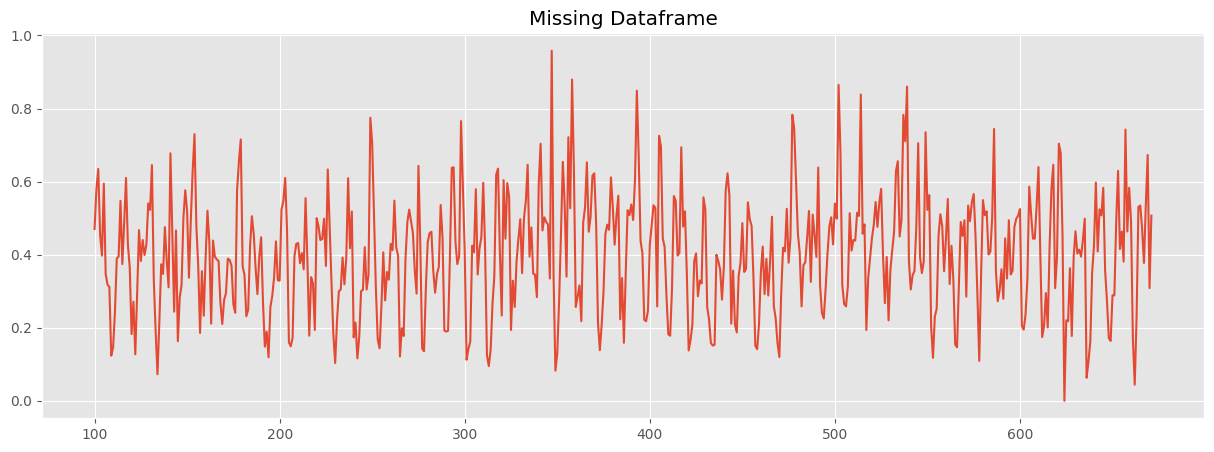

In [55]:
creator.plot(save_path='results/missing_data.png')

### Training

2023-11-04 14:49:19.055 | INFO     | modules.train:train:84 - Model 1/2: RandomForestRegressor
2023-11-04 14:49:19.057 | INFO     | modules.train:train:89 - Fitting the model RandomForestRegressor
2023-11-04 14:49:19.058 | INFO     | modules.train:train:103 - Cache miss 1760141440592


┌──────────────────────┬───────────┬───────────┬───────────────┬───────────┬──────────────┬────────────────┬─────────────┬───────────────────────┬──────────────────┬───────────────────┬──────────────────────────┬──────────────┬────────┬───────────┬──────────────┬─────────┬────────────┐
│ Model                │ bootstrap │ ccp_alpha │ criterion     │ max_depth │ max_features │ max_leaf_nodes │ max_samples │ min_impurity_decrease │ min_samples_leaf │ min_samples_split │ min_weight_fraction_leaf │ n_estimators │ n_jobs │ oob_score │ random_state │ verbose │ warm_start │
├──────────────────────┼───────────┼───────────┼───────────────┼───────────┼──────────────┼────────────────┼─────────────┼───────────────────────┼──────────────────┼───────────────────┼──────────────────────────┼──────────────┼────────┼───────────┼──────────────┼─────────┼────────────┤
│ RandomForestRegre... │ True      │ 0.0       │ squared_error │ None      │ 1.0          │ None           │ None        │ 0.0             

Generating windows: 100%|██████████| 552/552 [00:00<00:00, 11447.21it/s]
2023-11-04 14:49:21.155 | INFO     | modules.train:train:115 - Training completed in 2.10s
2023-11-04 14:49:21.156 | INFO     | modules.train:train:129 - Cache miss 1760140957840
Generating windows: 100%|██████████| 80/80 [00:00<00:00, 8047.40it/s]
2023-11-04 14:49:21.178 | INFO     | modules.train:train:150 - Similarity on predicting: 0.9186727818703198


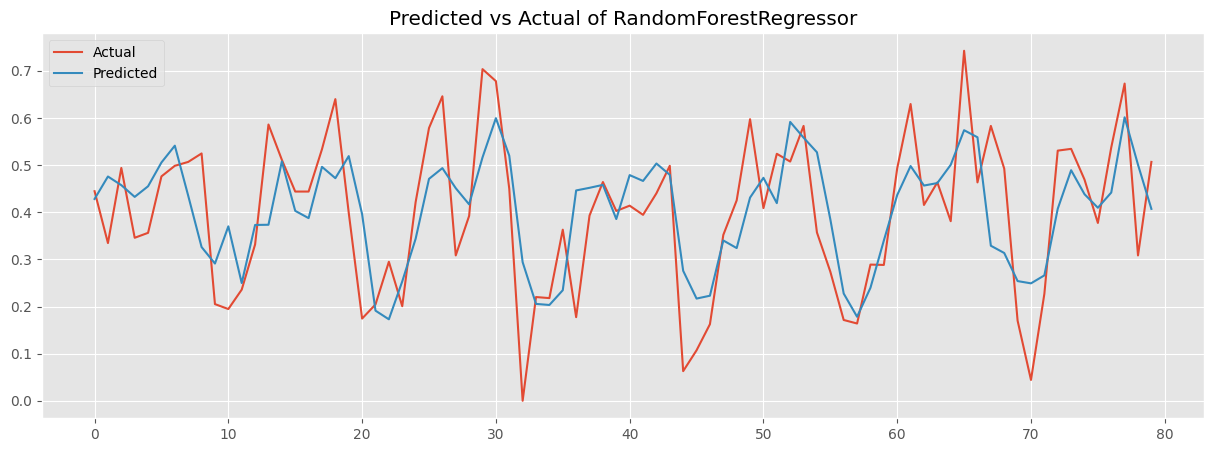

Forecasting: 100%|██████████| 100/100 [00:00<00:00, 202.91it/s]
2023-11-04 14:49:21.926 | INFO     | modules.train:train:165 - Similarity on forecasting: 0.923533141898159


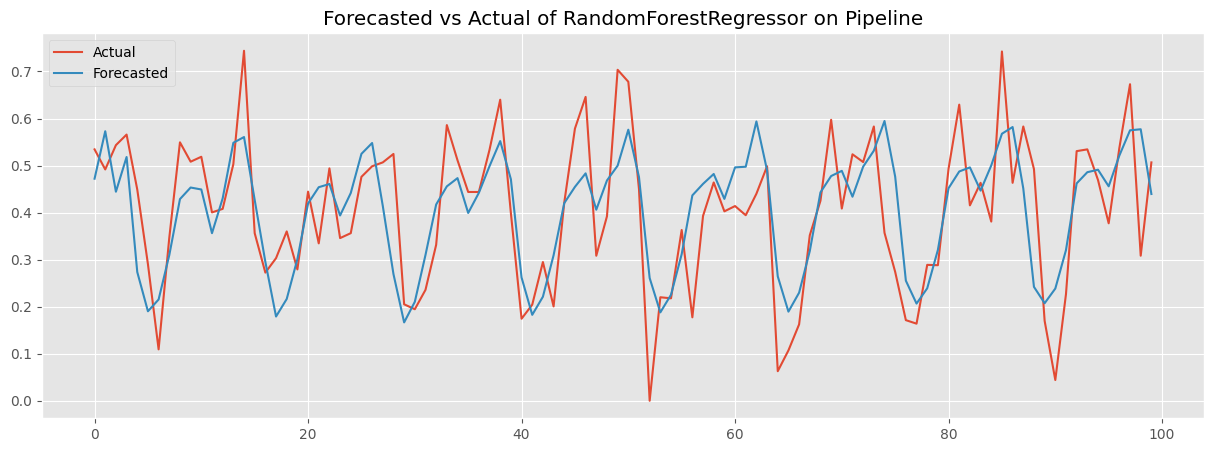

2023-11-04 14:49:22.330 | SUCCESS  | modules.train:train:173 - Model 1/2~RandomForestRegressor completed.
2023-11-04 14:49:22.331 | INFO     | modules.train:train:84 - Model 2/2: AdaBoostRegressor
2023-11-04 14:49:22.332 | INFO     | modules.train:train:89 - Fitting the model AdaBoostRegressor
2023-11-04 14:49:22.335 | INFO     | modules.train:train:101 - Cache hit 1760141440592


┌───────────────────┬────────────────┬───────────┬───────────────┬────────┬──────────────┬──────────────┐
│ Model             │ base_estimator │ estimator │ learning_rate │ loss   │ n_estimators │ random_state │
├───────────────────┼────────────────┼───────────┼───────────────┼────────┼──────────────┼──────────────┤
│ AdaBoostRegressor │ deprecated     │ None      │ 1.0           │ linear │ 50           │ None         │
└───────────────────┴────────────────┴───────────┴───────────────┴────────┴──────────────┴──────────────┘


2023-11-04 14:49:22.603 | INFO     | modules.train:train:115 - Training completed in 0.27s
2023-11-04 14:49:22.604 | INFO     | modules.train:train:127 - Cache hit 1760140957840
2023-11-04 14:49:22.616 | INFO     | modules.train:train:150 - Similarity on predicting: 0.9115815313555105


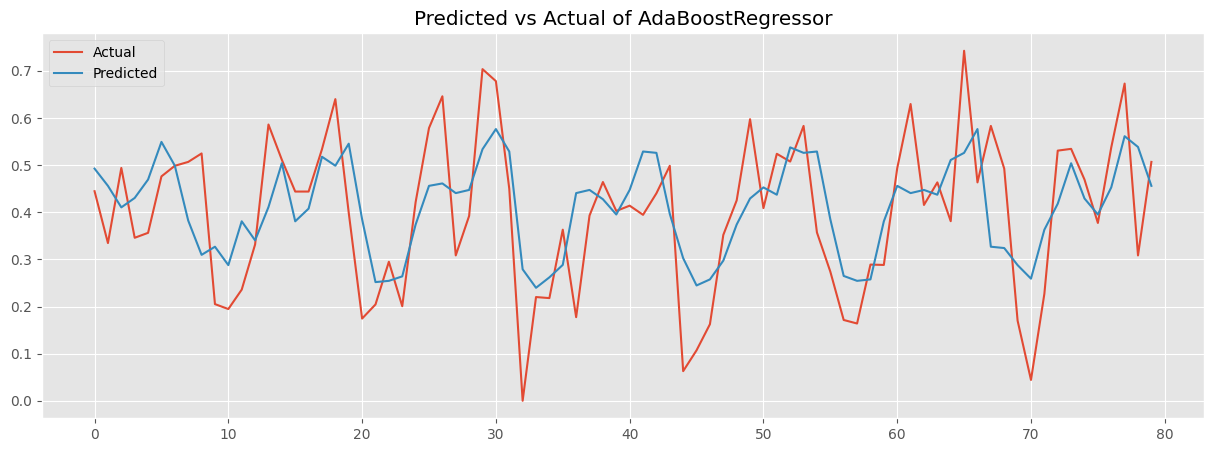

Forecasting: 100%|██████████| 100/100 [00:00<00:00, 157.88it/s]
2023-11-04 14:49:23.501 | INFO     | modules.train:train:165 - Similarity on forecasting: 0.9115017157865877


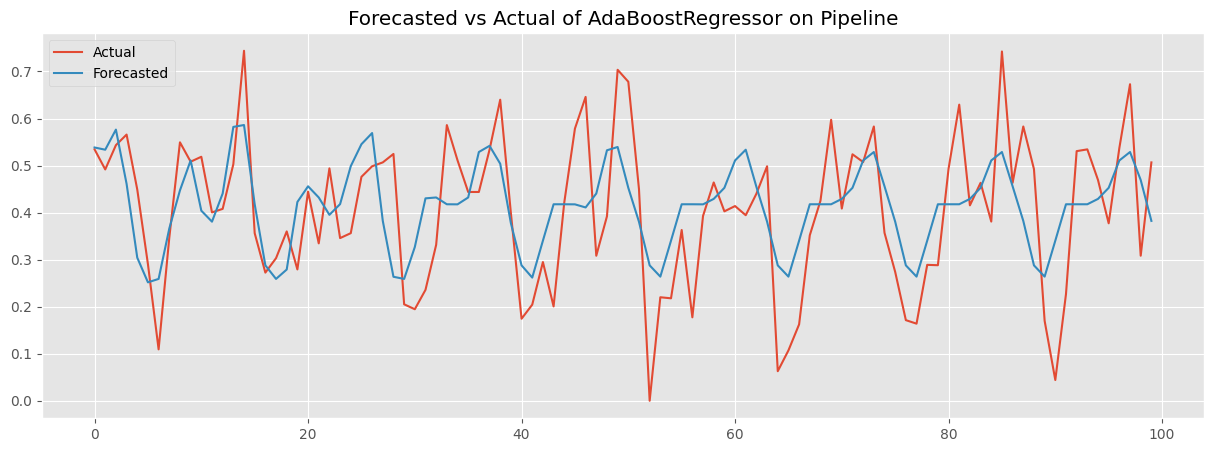

2023-11-04 14:49:23.905 | SUCCESS  | modules.train:train:173 - Model 2/2~AdaBoostRegressor completed.
2023-11-04 14:49:23.907 | INFO     | modules.train:reset:41 - All models have been reset.


In [56]:
# Training
trainer = Trainer(model=MODELS)
# combined_callback = Combined(n_models=len(MODELS), combination_mode='data_per', df=creator, save_directory="results")
sp = SavePlot(n_models=len(MODELS), save_directory="results")
cache = Cache(live_cache=True)

for train_df, test_df in creator:
    train_gen = WindowGenerator(train_df, WINDOW_SIZE, BATCH_SIZE)
    test_gen = WindowGenerator(test_df, WINDOW_SIZE, BATCH_SIZE)

    trainer.train(train_gen, test_gen, callbacks=[sp], cache=cache)
    trainer.reset()